In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score, rand_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans as skl_KMeans


In [3]:
from clustering import KMeans

def kmeans_display(X, label, centroid):
    X0 = X[label == 0]
    X1 = X[label == 1]
    X2 = X[label == 2]

    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize=4, alpha=.7, zorder=0)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize=4, alpha=.7, zorder=0)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize=4, alpha=.7, zorder=0)

    plt.scatter(centroid[0][0], centroid[0][1], c='yellow',
                s=150, marker='^', edgecolors='black', zorder=5)
    plt.scatter(centroid[1][0], centroid[1][1], c='yellow',
                s=150, marker='o', edgecolors='black', zorder=5)
    plt.scatter(centroid[2][0], centroid[2][1], c='yellow',
                s=150, marker='s', edgecolors='black', zorder=5)

    plt.show()


In [3]:
df, target = load_iris(return_X_y=True, as_frame=True)

In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


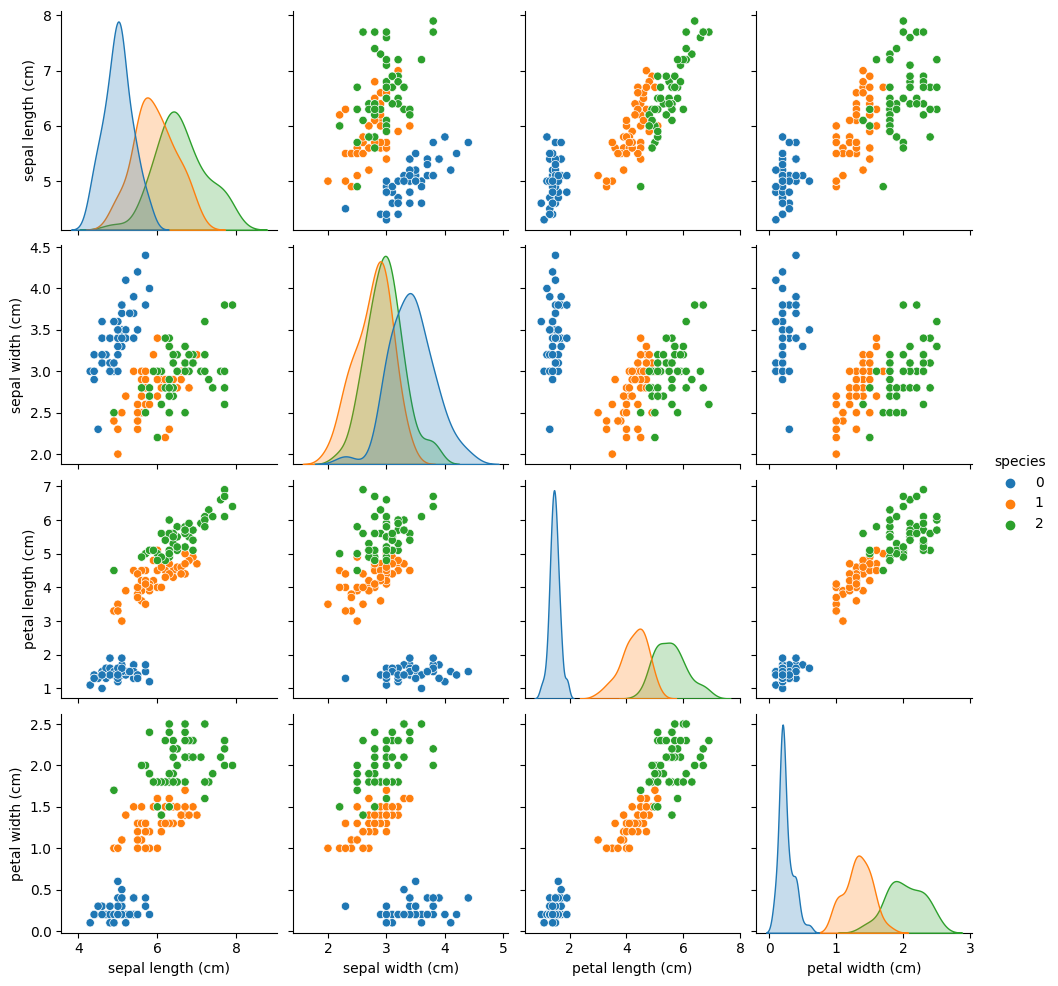

In [11]:

df['species'] = target.astype(str)
sns.set_palette('tab10')
sns.pairplot(df, hue="species")
plt.show()

### Evaluate on Iris Dataset


In [88]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
from sklearn.cluster import KMeans as skl_KMeans
model = skl_KMeans(n_clusters=3)
model.fit(X_train)
pred_centroids = model.cluster_centers_
pred_labels = model.predict(X_test)
print('Adjusted Rand score:', adjusted_rand_score(y_test, pred_labels))


Adjusted Rand score: 0.7319778188539742


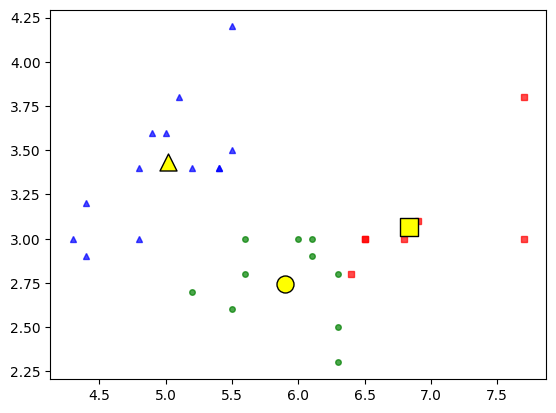

In [15]:
kmeans_display(X_test, pred_labels, pred_centroids)


In [89]:
scaler = MinMaxScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = KMeans(n_clusters=3, init='al-daoud')
model.fit(scaled_X_train)
pred_centroids = model.centroids
pred_labels = model.predict(scaled_X_test)
print('Adjusted Rand score:', adjusted_rand_score(y_test, pred_labels))


Adjusted Rand score: 0.9175316365704536


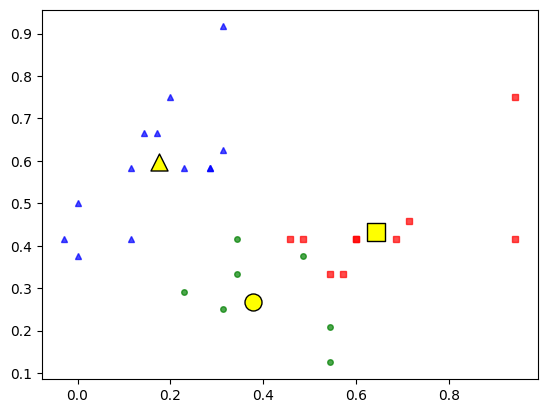

In [17]:
kmeans_display(scaled_X_test, pred_labels, pred_centroids)


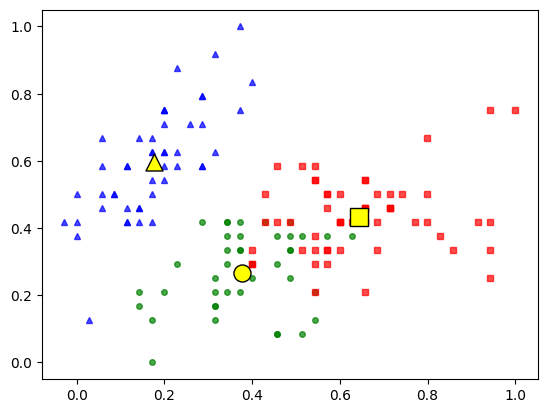

In [91]:
scaled_X = scaler.transform(X)
kmeans_display(scaled_X, model.predict(scaled_X), pred_centroids)

### Evaluate on Dummy Dataset


In [7]:
np.random.seed(123)
means = [[2, 2], [8, 3], [3, 6]]
cov = np.identity(2)
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis=0)
n_clusters = 3
y = np.array([0]*N+[1]*N+[2]*N).T


In [8]:
mean_rand_score=0
mean_adjusted_rand_score=0
for i in range(100):
    model = KMeans(n_clusters=n_clusters, init='random')
    model.fit(X)
    pred_centroids = model.centroids
    pred_labels = model.predict(X)
    mean_rand_score += rand_score(y, pred_labels)
    mean_adjusted_rand_score += adjusted_rand_score(y, pred_labels)

print(mean_rand_score/100, mean_adjusted_rand_score/100)


0.9585109984434075 0.9127902630639134


In [9]:
mean_rand_score = 0
mean_adjusted_rand_score = 0
for i in range(100):
    model = KMeans(n_clusters=n_clusters, init='al-daoud')
    model.fit(X)
    pred_centroids = model.centroids
    pred_labels = model.predict(X)
    mean_rand_score += rand_score(y, pred_labels)
    mean_adjusted_rand_score += adjusted_rand_score(y, pred_labels)

print(mean_rand_score/100, mean_adjusted_rand_score/100)


0.981618857015789 0.958615309206241


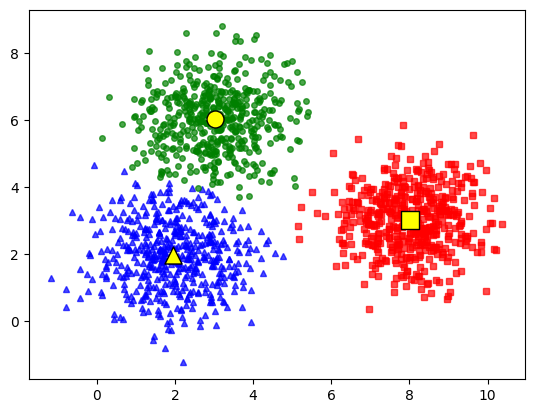

In [10]:
kmeans_display(X, pred_labels, pred_centroids)


In [11]:
from timeit import timeit
setup="""
import numpy as np

def al_daoud_init1(n_clusters, X: np.ndarray):
    max_var_index = np.argmax(np.var(X, axis=0))
    new_X = X[X[:, max_var_index].argsort()]
    X_clusters = np.array_split(new_X, n_clusters)
    return [cluster[cluster[:, max_var_index] >= np.median(cluster, axis=0)[max_var_index]][0] for cluster in X_clusters]

def get_median_index_of_subset(n_samples, n_clusters):
    a = n_samples//n_clusters
    b = n_samples % n_clusters
    d = np.array([a+1]*b + [a]*(n_clusters-b))
    c = d//2
    c[1:] += (np.cumsum(d[:-1]))
    return c

def al_daoud_init2(n_clusters, X: np.ndarray):

    max_var_index = np.argmax(np.var(X, axis=0))
    median_indexes = get_median_index_of_subset(X.shape[0], n_clusters)
    return X[np.argpartition(X[:, max_var_index], median_indexes)][median_indexes, :]

np.random.seed(123)
means = [[2, 2], [8, 3], [3, 6]]
cov = np.identity(2)
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis=0)
n_clusters = 3
original_labels = np.array([0]*N+[1]*N+[2]*N).T
"""

stmt1 = "al_daoud_init1(n_clusters, X)"
stmt2 = "al_daoud_init2(n_clusters, X)"


In [12]:
print(timeit(stmt1, setup=setup, number=1000))
print(timeit(stmt2, setup=setup, number=1000))

0.32501280000000055
0.12134849999999986


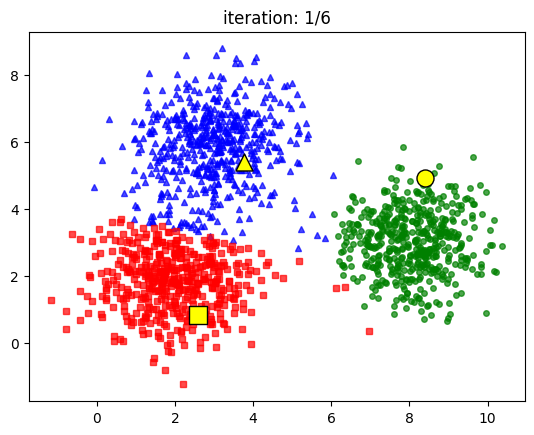

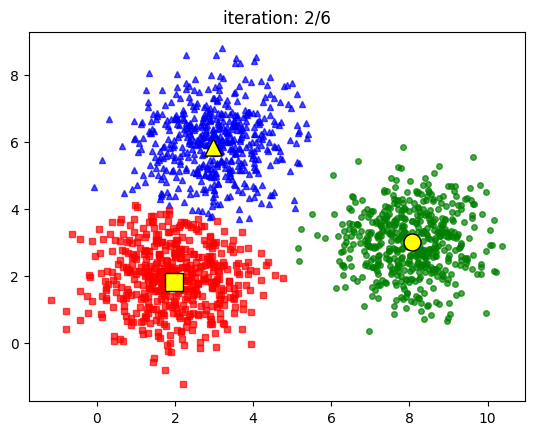

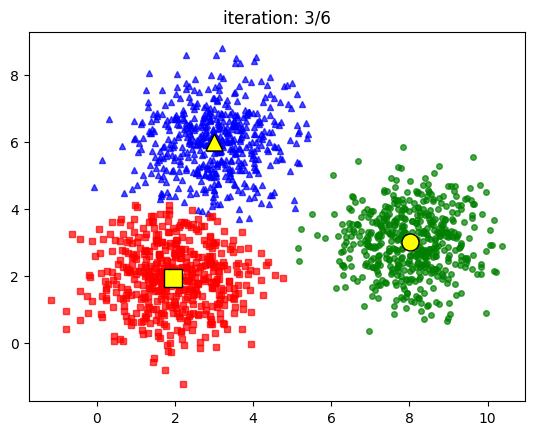

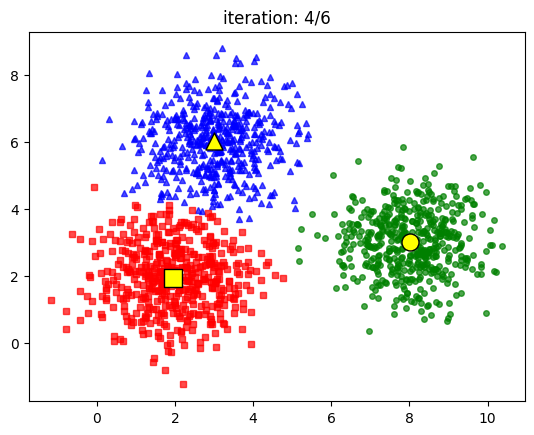

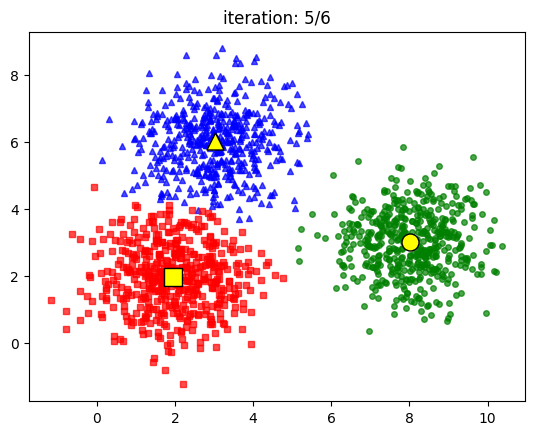

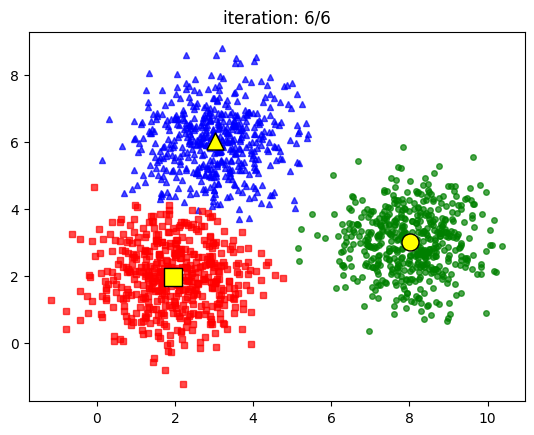

In [13]:
_, centroids, labels = KMeans(n_clusters=n_clusters, init='random').fit(X, history=True)

n = len(centroids)
for i in range(n):
    plt.title("iteration: {}/{}".format(i+1, n))
    kmeans_display(X, labels[i], centroids[i])
